In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
import math

### Set - Up

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Parameters
noise_dim = 10
image_dim = 28
batch_size = 64

max_translate = 6
max_rotation = 20

In [ ]:
# Load MNIST and extract one sample per class
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

base_images, base_labels = [], []
seen_classes = set()
for img, label in train_dataset:
    if label not in seen_classes:
        base_images.append(img)
        base_labels.append(label)
        seen_classes.add(label)
    if len(seen_classes) == 10:
        break
base_images = torch.stack(base_images, dim=0).to(device)
base_labels = torch.tensor(base_labels, dtype=torch.long).to(device)

In [ ]:
# Define Classifier CNN
class ClassifierCNN(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(16 * 7 * 7, 64),
            nn.ReLU(),
        )
        self.head = nn.Linear(64, num_outputs)

    def forward(self, x):
        features = self.feature_extractor(x)
        return self.head(features)


### Utilities

In [ ]:
# Evaluation function
def evaluate(model):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return correct / total

### Experiment

In [ ]:
def run(startup_proportion, total_training_steps, eval_interval):
    # Initialize models and optimizers
    classifier = ClassifierCNN(num_outputs=1).to(device)
    optimizer_c = torch.optim.Adam(classifier.parameters(), lr=3e-4)

    # Fake data generator (simple random noise)
    def generate_fake_batch(batch_size):
        imgs = torch.rand(batch_size, 1, 28, 28, device=device)
        imgs = (imgs > 0.5).float()
        labels = imgs.sum(dim=[1,2,3])
        return imgs, labels

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    steps_per_epoch = len(train_loader)

    # Calculate how much training is online vs disk
    online_steps = int(startup_proportion * total_training_steps)
    disk_steps = total_training_steps - online_steps
    disk_epochs = math.ceil(disk_steps / steps_per_epoch)

    scheduler_c = torch.optim.lr_scheduler.OneCycleLR(
        optimizer_c, max_lr=3e-4, total_steps=total_training_steps
    )

    criterion = nn.MSELoss()

    start = time.time()

    # Online training
    print('Synthetic Training...')
    loss_history = []
    accuracy_history = []
    for step in range(1, online_steps + 1):
        fake_images, fake_labels = generate_fake_batch(batch_size)

        optimizer_c.zero_grad()
        preds = classifier(fake_images)
        loss = criterion(preds.squeeze(), fake_labels)
        loss.backward()
        scheduler_c.step()
        optimizer_c.step()

        if step % eval_interval == 0:
            loss_history.append(loss.item())
            print(f'Loss: {loss.item():.4f}')

    # Replace classifier head for real MNIST classification
    classifier.head = nn.Linear(64, 10).to(device)
    optimizer_c = torch.optim.Adam(classifier.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss()

    # Disk training
    print('Natural Training...')
    step = 0
    for epoch in range(1, disk_epochs + 1):
        for real_images, real_labels in train_loader:
            if step >= disk_steps:
                break
            real_images, real_labels = real_images.to(device), real_labels.to(device)

            optimizer_c.zero_grad()
            logits = classifier(real_images)
            loss = criterion(logits, real_labels)
            loss.backward()
            scheduler_c.step()
            optimizer_c.step()

            step += 1

            if step % eval_interval == 0:
                acc = evaluate(classifier)
                accuracy_history.append(acc)
                print(f'Loss: {loss.item():.4f} | Accuracy: {acc:.4f}')

    end = time.time()

    elapsed_time = end - start
    return elapsed_time, accuracy_history, loss_history

In [ ]:
# Main Experiment Loop
total_steps  = 200
eval_interval = 5
percentages   = [round(0.1 * p, 2) for p in range(10)]

times        = {}
losses       = {}
accuracies   = {}

for percent in percentages:
    print(f"\nTesting {percent*100}% online...")
    t, a, l = run(percent, total_steps, eval_interval)

    times[percent] = t
    losses[percent] = l
    accuracies[percent] = a


Testing 0.0% online...
Synthetic Training...
Natural Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Loss: 2.2734 | Accuracy: 0.1135
Loss: 2.3119 | Accuracy: 0.1135
Loss: 2.2860 | Accuracy: 0.1135
Loss: 2.2681 | Accuracy: 0.1135
Loss: 2.2748 | Accuracy: 0.1135
Loss: 2.2638 | Accuracy: 0.1533
Loss: 2.2519 | Accuracy: 0.3101
Loss: 2.2271 | Accuracy: 0.4094
Loss: 2.1983 | Accuracy: 0.4397
Loss: 2.2122 | Accuracy: 0.5063
Loss: 2.2013 | Accuracy: 0.5421
Loss: 2.1310 | Accuracy: 0.5385
Loss: 2.1455 | Accuracy: 0.6238
Loss: 2.0914 | Accuracy: 0.7376
Loss: 2.0597 | Accuracy: 0.6963
Loss: 2.0219 | Accuracy: 0.6392
Loss: 1.9423 | Accuracy: 0.6347
Loss: 1.9622 | Accuracy: 0.6315
Loss: 1.8954 | Accuracy: 0.6673
Loss: 1.7691 | Accuracy: 0.7358
Loss: 1.7522 | Accuracy: 0.7138
Loss: 1.7346 | Accuracy: 0.7091
Loss: 1.6787 | Accuracy: 0.6763
Loss: 1.6258 | Accuracy: 0.7405
Loss: 1.4377 | Accuracy: 0.7788
Loss: 1.4224 | Accuracy: 0.7470
Loss: 1.3963 | Accuracy: 0.7309
Loss: 1.2420 | Accuracy: 0.7716
Loss: 1.1330 | Accuracy: 0.7905
Loss: 1.0911 | Accuracy: 0.8013
Loss: 1.0664 | Accuracy: 0.7857
Loss: 0.

### Analysis

Plot times

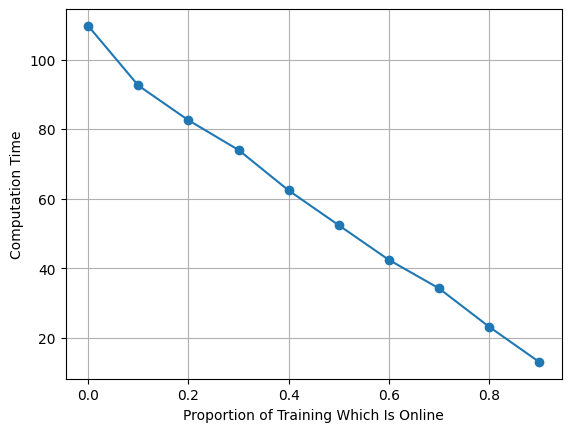

In [ ]:
# Plotting
x  = list(times.keys())
tm = list(times.values())

plt.plot(x, tm, marker='o')
plt.xlabel('Proportion of Training Which Is Online')
plt.ylabel('Computation Time')
plt.title('')
plt.grid(True)
plt.show()

Plot Final Accuracies

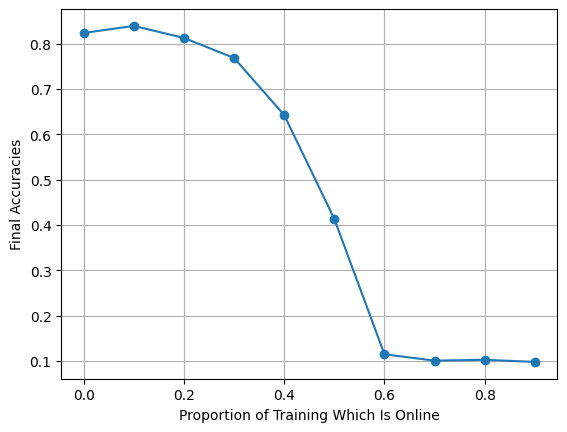

In [ ]:
fa = [acc[-1] if acc else 0 for acc in accuracies.values()]
plt.plot(x, fa, marker='o')
plt.xlabel('Proportion of Training Which Is Online')
plt.ylabel('Final Accuracies')
plt.title('')
plt.grid(True)
plt.show()

Plot Final Losses

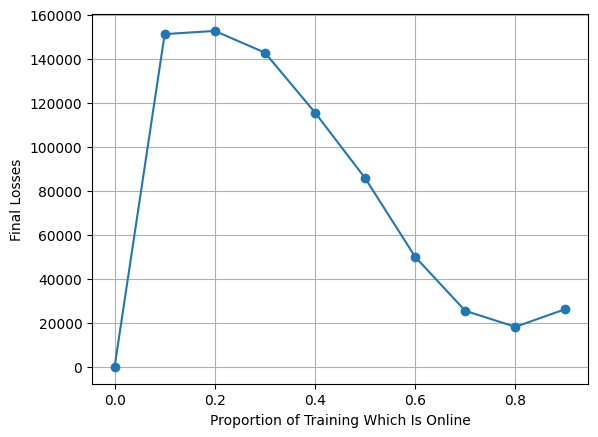

In [ ]:
fl = [l[-1] if l else 0 for l in losses.values()]
plt.plot(x, fl, marker='o')
plt.xlabel('Proportion of Training Which Is Online')
plt.ylabel('Final Losses')
plt.title('')
plt.grid(True)
plt.show()

In [1]:
import matplotlib.pyplot as plt

x = list(times.keys())
tm = list(times.values())

plt.figure(figsize=(6, 4))  # Slightly bigger figure
plt.plot(x, tm, marker='o', markersize=8, linestyle='-', linewidth=2)

plt.xlabel('Proportion of Training Which Is Online', fontsize=14)
plt.ylabel('Computation Time (s)', fontsize=14)
plt.title('Training Time vs. Online Warmup', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


NameError: name 'times' is not defined